In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from realism.realism_utils import make_orderbook_for_analysis, MID_PRICE_CUTOFF
from util.plotting import liquidity_telemetry as lt

In [46]:
def get_delays_and_profits(paths):
    output = None
    slave_ids = {}
    master_ids = {}
    for path in paths:
        master_profit = None
        delays = {}
        slave_ids[path] = []
        for file in os.listdir(path):
            if 'HerdMasterAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    master_profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    m_id = int(file.split('HerdMasterAgent')[1].split('.')[0])
                    master_ids[path] = m_id
                except (IndexError, KeyError):
                    continue                
            if 'HerdSlaveAgent' in file:
                try:
                    s_id = int(file.split('HerdSlaveAgent')[1].split('.')[0])
                    slave_ids[path].append(s_id)
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    delay = df.loc[df.EventType == 'DELAY', 'Event'].values[0]
                    profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    delays[delay] = profit
                except (IndexError, KeyError):
                    continue
        x, y = np.asarray(sorted(delays.items()))[:, 0], np.asarray(sorted(delays.items()))[:, 1]
        temp = pd.DataFrame({'DELAY': x, 'SLAVE_PROFIT': y})
        temp['MASTER_PROFIT'] = master_profit
        temp['SIMULATION'] = path
        if output is None:
            output = temp
        else:
            output = output.append(temp)
    output['PERCENT'] = output.SLAVE_PROFIT/output.MASTER_PROFIT
    output = output.sort_values(by='DELAY').reset_index(drop=True)
    return output, slave_ids, master_ids

In [4]:
def get_herd_impact(paths, slaves):
    output = None
    for path in paths:
        df = pd.read_pickle(os.path.join(path,'EXCHANGE_AGENT.bz2'), compression='bz2')
        df = df[df.EventType == 'ORDER_ACCEPTED']
        df.reset_index(inplace=True)
        temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
        temp['EventTime'] = df.EventTime
        t = temp[temp.agent_id.isin(slaves[path])][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
        t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
        t['SIMULATION'] = path
        t['tot_vol'] = t1.tot_vol
        
        output = t if output is None else output.append(t)
    return output

Configuration 1

In [ ]:
# end-time 12:00:00
# master-window 1e+9
# slave-min-delay 1e+1 
# slave-max-delay 1e+8
# 1 master
# 40 slaves
# limit orders

# Master Strategy
# if ask < r_f:
#     buy = True
#     p = ask - adjust_int
#     size = self.getHoldings(self.symbol)*(-1) if self.getHoldings(self.symbol) < 0 else self.size
#     if p >= r_f:
#         return
# elif bid > r_f:
#     buy = False
#     p = bid + adjust_int
#     size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#     if p <= r_f:
#         return
# if self.currentTime+delta < self.mkt_close:
#     self.placeLimitOrder(self.symbol, size, buy, p)

# Slave Strategy
# if order['is_buy_order']:
#     quantity = order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])



PATHS = ["log/herd01_2_5_hour_0/", "log/herd01_2_5_hour_1/", "log/herd01_2_5_hour_2/", "log/herd01_2_5_hour_3/", 
         "log/herd01_2_5_hour_4/", "log/herd01_2_5_hour_5/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [ ]:
t = get_herd_impact(PATHS, slave_ids)

In [ ]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100

In [ ]:
#t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Configuration 2

In [ ]:
# Changed slave strategy to this.


# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(self.symbol) * (-1) if self.getHoldings(self.symbol) < 0 else order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])


PATHS = ["log/herd01_2_5_hour_0_s/", "log/herd01_2_5_hour_1_s/", "log/herd01_2_5_hour_2_s/", "log/herd01_2_5_hour_3_s/", 
         "log/herd01_2_5_hour_4_s/", "log/herd01_2_5_hour_5_s/", "log/herd01_2_5_hour_6_s/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config. 3

In [ ]:
# Changed limit orders to market orders and moved the message from accepted to placed
# changed to master-window 5e+9


PATHS = ["log/herd01_2_5_hour_1_t/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//3
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.75, -1, -2], xmin=[xmin, xmin, xmin, xmin], xmax=[xmax, xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 4.

In [ ]:
# end-time 12:00:00
# changed to master-window 5e+9
# slave-min-delay 1e+1 
# changed to slave-max-delay 1e+9
# 1 master
# changed to 60 slaves
# changed to 100 momentum agents
# back to limit orders

# Master Strategy
# if ask < r_f:
#     buy = True
#     p = ask - adjust_int
#     size = self.getHoldings(self.symbol)*(-1) if self.getHoldings(self.symbol) < 0 else self.size
#     if p >= r_f:
#         return
# elif bid > r_f:
#     buy = False
#     p = bid + adjust_int
#     size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#     if p <= r_f:
#         return
# if self.currentTime+delta < self.mkt_close:
#     self.placeLimitOrder(self.symbol, size, buy, p)

# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(symbol) * (-1) if self.getHoldings(symbol) < 0 else quantity
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])



PATHS = ["log/herd01_2_5_hour_1_z/", "log/herd01_2_5_hour_2_z/", "log/herd01_2_5_hour_3_z/", 
         "log/herd01_2_5_hour_4_z/", "log/herd01_2_5_hour_5_z/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.5, 0.75, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 5

In [ ]:
# I try to make it a bit more realistic with the herd representing a small volume of the total transactions.
# changed to master-window 3e+9 
# changed to slave-max-delay 1e+9
# changed order size from 5 to 2
# 1 master
# changed to 40 slaves
# changed to 300 momentum agents
# limit orders

# Master Strategy unchanged

# Slave Strategy unchanged


PATHS = ["log/herd01_2_5_hour_1_x/", "log/herd01_2_5_hour_2_x/", "log/herd01_2_5_hour_3_x/", 
         "log/herd01_2_5_hour_4_x/", "log/herd01_2_5_hour_5_x/", "log/herd01_2_5_hour_6_x/", 
         "log/herd01_2_5_hour_7_x/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.75, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [ ]:
t = get_herd_impact(PATHS, slave_ids)

In [ ]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100
t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 6

In [47]:
# Herd02 config

PATHS = []
for file in os.listdir('log'):
    if 'herd02' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,125376.0,41719.0,43856,log/herd02_2_hour_2_seed_2083814687,0.951272
1,1228942.0,53304.0,49830,log/herd02_2_hour_2_seed_4000937544,1.069717
2,1663281.0,44406.0,49500,log/herd02_2_hour_1_seed_630311759,0.897091
3,1813274.0,74459.0,78062,log/herd02_2_hour_2_seed_878959199,0.953844
4,1950374.0,71999.0,38881,log/herd02_2_hour_2_seed_3001592395,1.851779
...,...,...,...,...,...
1915,997934851.0,121332.0,214954,log/herd02_2_hour_2_seed_515183663,0.564456
1916,998251958.0,1657.0,32438,log/herd02_2_hour_2_seed_2141303910,0.051082
1917,998607901.0,-41084.0,42154,log/herd02_2_hour_1_seed_491263,-0.974617
1918,999924862.0,-4096.0,45318,log/herd02_2_hour_2_seed_4070471979,-0.090384


In [28]:
df['g'] = df.index//120
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                SLAVE_PROFIT               MASTER_PROFIT  \
            mean           std          mean           std          mean   
g                                                                          
0   3.433230e+07  2.056562e+07  63466.816667  29734.871514  64139.508333   
1   1.015453e+08  1.734007e+07  56863.000000  30296.589018  60750.183333   
2   1.611788e+08  1.637971e+07  61824.433333  54247.096602  66302.116667   
3   2.184287e+08  1.751734e+07  54598.075000  42892.776698  60948.700000   
4   2.834293e+08  1.759740e+07  51163.216667  45951.809598  62632.658333   
5   3.406860e+08  1.658018e+07  61720.133333  60454.361040  62976.258333   
6   4.001815e+08  1.624445e+07  50403.133333  58833.181175  61788.775000   
7   4.571326e+08  1.758598e+07  51746.550000  66307.385238  60351.175000   
8   5.203623e+08  1.904791e+07  49820.125000  62311.819997  68739.491667   
9   5.845590e+08  1.779039e+07  29713.466667  52984.947778  62585.641667   
10  6.516697e+08  1.798363e+07  41586.966667  54440.548299  69644.741667   
11  7.168406e+08  1.909394e+07  25304.000000  47886.639492  63016.566667   
12  7.795049e+08  2.095656e+07  28327.800000  50762.656226  66050.608333   
13  8.474241e+08  1.906224e+07  23896.816667  54265.195036  62057.333333   
14  9.097514e+08  1.592024e+07  18049.625000  65343.346128  60807.575000   
15  9.701669e+08  1.815277e+07  14220.933333  58114.352782  61426.666667   

                   PERCENT            
             std      mean       std  
g                                     
0   32947.719114  1.030079  0.319806  
1   33157.350142  0.983147  0.378608  
2   42440.439283  0.934544  0.479524  
3   30032.254108  0.919043  0.555278  
4   37837.834159  0.836769  0.646484  
5   36222.187249  0.969595  0.765299  
6   30829.507748  0.830012  0.906327  
7   33329.179114  0.795656  0.941456  
8   40964.217614  0.715047  0.937315  
9   37522.859066  0.432886  0.846959  
10  45522.464191  0.619189  0.894767  
11  32008.855452  0.402646  0.891162  
12  38057.365529  0.413373  0.874207  
13  34177.481594  0.372469  0.967450  
14  26176.226508  0.343548  1.339283  
15  39426.121521  0.224002  1.094445

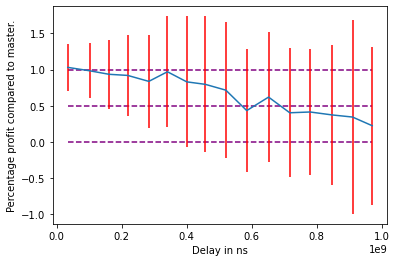

In [29]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.5, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [62]:
temp[temp.agent_id == master_ids[PATHS[0]]][['EventTime', 'quantity']].set_index('EventTime')[560:].head(50)

,quantity
EventTime,
2020-06-03 11:08:33.598548375,1
2020-06-03 11:08:38.605819865,1
2020-06-03 11:08:53.627634335,2
2020-06-03 11:08:58.634905875,2
2020-06-03 11:09:03.642177365,2
2020-06-03 11:09:18.663991835,2
2020-06-03 11:09:28.678534815,2
2020-06-03 11:09:33.685806305,2
2020-06-03 11:09:38.693077795,2


In [ ]:
df = pd.read_pickle(os.path.join(path,'EXCHANGE_AGENT.bz2'), compression='bz2')
df = df[df.EventType == 'ORDER_ACCEPTED']
df.reset_index(inplace=True)
temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
temp['EventTime'] = df.EventTime
t = temp[temp.agent_id.isin(slaves[path])][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
t['SIMULATION'] = path
t['tot_vol'] = t1.tot_vol

output = t if output is None else output.append(t)


In [30]:
t = get_herd_impact(PATHS, slave_ids)
t

KeyboardInterrupt: 

In [ ]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100
t.reset_index(inplace=True)

In [ ]:
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [ ]:
fun = pd.read_pickle(os.path.join(PATHS[10],'fundamental_ABM.bz2'), compression='bz2')

In [17]:
df = pd.read_pickle(os.path.join(PATHS[10],'EXCHANGE_AGENT.bz2'), compression='bz2')
df = df[df.EventType == 'ORDER_EXECUTED']
df.reset_index(inplace=True)

In [18]:
temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
temp['EventTime'] = df.EventTime

In [19]:
temp = temp.drop_duplicates(subset=['EventTime'])[['EventTime', 'fill_price']].reset_index(drop=True).set_index('EventTime').astype('int')
temp

,fill_price
EventTime,
2020-06-03 09:30:00.000004214,99936
2020-06-03 09:30:00.000011155,99936
2020-06-03 09:30:00.000020024,99936
2020-06-03 09:30:00.000028937,99936
2020-06-03 09:30:00.000039601,99936
...,...
2020-06-03 11:29:58.609153393,99623
2020-06-03 11:29:58.830039933,99624
2020-06-03 11:29:58.894654518,99624


<AxesSubplot:xlabel='EventTime'>

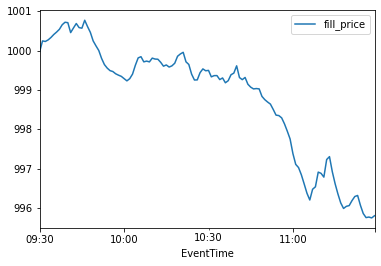

In [23]:
(temp.resample('1T').mean()/100).plot()

<AxesSubplot:xlabel='FundamentalTime'>

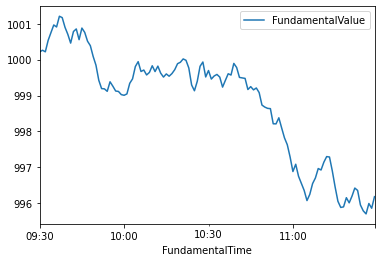

In [26]:
(fun.resample('1T').mean()/100).plot()